In [1]:
import pandas as pd
import glob
import numpy as np
import datetime
from sklearn.manifold import TSNE
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
path = './data/csv/oprt/'
allFiles = glob.glob(path + "*")
df_oprt = pd.DataFrame()
list_ = []
for file_ in allFiles:
    frame = pd.read_csv(file_, sep=';', header=None, names=("perd_arrt_info","code_sens_imput","numr_pers","sum_mt_brut","nb_annl_oprt","nb_forc_oprt"))
    list_.append(frame)
df_oprt = pd.concat(list_)

In [3]:
path = './data/csv/profil/'
allFiles = glob.glob(path + "*")
df_profil = pd.DataFrame()
list_ = []
dateparse = lambda dates: pd.datetime.strptime(dates,'%Y-%m-%d %H:%M:%S.%f')
for file_ in allFiles:
    frame = pd.read_csv(file_, sep=';', header=None, index_col = 'numr_pers', names=("numr_pers","code_civl","code_sexe","date_nais","age_calcul","age_sortie","nb_entt_titl_simp_ouvr","nb_entt_titl_join_ouvr","date_arrv_clnt_res","date_sort_clnt","date_decs","code_csp","code_type_regm_matr","code_type_sitt_faml","code_segm_comp","code_ins_pays_nais","code_dept_nais","code_segm_frqn_clnt","nb_jour_ancn_clnt","code_segm_unvr_v2"), parse_dates=("date_nais"), date_parser=dateparse)
    list_.append(frame)
df_profil = pd.concat(list_)
# Keep only relevant columns
df_profil = df_profil[["code_sexe","date_nais","date_sort_clnt","date_decs"]]

In [4]:
def dateparse(dates):
    if dates != '\\N':
        return pd.datetime.strptime(dates,'%Y-%m-%d %H:%M:%S.%f')
    else:
        return None
    
df_profil["date_nais"]= df_profil.date_nais.map(dateparse)
df_profil["date_sort_clnt"]= df_profil.date_sort_clnt.map(dateparse)
df_profil["date_decs"]= df_profil.date_decs.map(dateparse)

In [5]:
df_oprt_pivot = pd.pivot_table(df_oprt, values=['sum_mt_brut','nb_annl_oprt'], aggfunc=sum, index=['numr_pers'], columns=['perd_arrt_info','code_sens_imput']).fillna(0)

In [6]:
df_join = pd.merge(df_oprt_pivot, df_profil, how='left', left_index=True, right_index= True)

In [29]:
df_test = df_join.ix[:,(0,1,2,3,4,5,6,7,8,9,10,11,110,111)]
# Labelisation
df_test["churn"] = (df_test.date_sort_clnt >= datetime.datetime(2013, 4, 1, 0 , 0)) & (df_test.date_sort_clnt <= datetime.datetime(2013, 9, 30, 0 , 0))
df_test["churn"] = df_test["churn"].map(lambda x: 1 if x else 0)
# Delete dead people
df_test = df_test[df_test["date_decs"].isnull()]

In [30]:
# Sampling data for training
df_test = df_test.sample(frac=0.1)
# = df_test.sample(n=10000)

In [31]:
from sklearn.cross_validation import train_test_split
X = df_test.ix[:,(0,1,2,3,4,5,6,7,8,9,10,11)]
y = df_test.ix[:,"churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [32]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)

#clf = SVC()
#clf.fit(X_train, y_train)
#class_weight = 1/(len(y_train[y_train == True])/len(y_train))

clf = RandomForestClassifier(class_weight={0:38})
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 20}, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Precision : 0.564971751412 %
Recall : 10.0 %
f1: 1.06951871658 %
Accuracy: 97.3947331362 %
confusion matrix
[[6915    9]
 [ 176    1]]
Normalized confusion matrix
[[ 0.99870017  0.00129983]
 [ 0.99435028  0.00564972]]


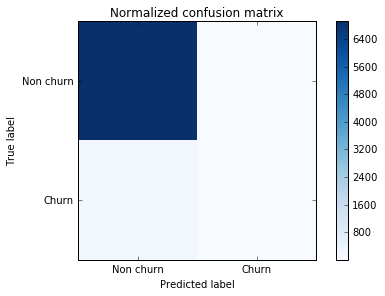

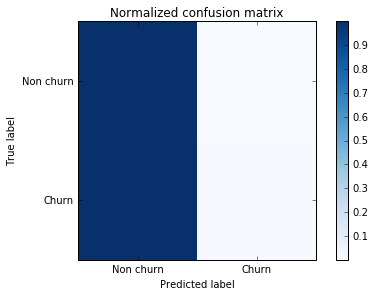

In [33]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(X_test)
print("Precision : " + str(precision_score(y_pred,y_test.values)*100) + ' %')
print("Recall : " + str(recall_score(y_pred,y_test.values)*100) + ' %')
print("f1: " + str(f1_score(y_pred,y_test.values)*100) + ' %')
print("Accuracy: " + str(clf.score(X_test,y_test.values)*100) + ' %')

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ("Non churn","Churn"))
    plt.yticks(tick_marks, ("Non churn","Churn"))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(y_test, y_pred)
print('confusion matrix')
print(cm)
plt.figure()
plot_confusion_matrix(cm, title='Normalized confusion matrix')

cm_normalized = cm.astype('float64') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

In [ ]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
data_tsne = model.fit_transform(X_train) 
plt.figure(figsize=(15,15))
plt.scatter(data_tsne[:,0],data_tsne[:,1],c=y_train, cmap ='bwr')